# $$\text{WEATHER - SEOUL}$$
### $$\textbf{Analiza danych rzeczywistych przy pomocy modelu ARMA}$$

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

## 1. Wstęp

    1.1. Czy w analizowanych danych występują braki?

In [38]:
# data = pd.read_csv('mumbai.csv')
# data['datetime'] = pd.to_datetime(data['datetime'], format="%d-%m-%Y")

In [39]:
data = pd.read_csv('seoul.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data.isnull().sum()

name                  0
datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          386
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk            9
sunrise               0
sunset                0
moonphase             0
conditions            0
description           0
icon                  0
stations              0
dtype: int64

In [40]:
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,seoul,2022-01-01,2.0,-10.2,-4.7,0.3,-15.0,-6.6,-15.2,44.3,...,9.9,5,NaN,2022-01-01T07:46:54,2022-01-01T17:24:04,0.94,Clear,Clear conditions throughout the day.,clear-day,"47098099999,47112099999,47119099999,4712209999..."
1,seoul,2022-01-02,2.6,-4.4,-1.1,-0.5,-8.6,-4.0,-8.4,58.9,...,10.1,5,NaN,2022-01-02T07:47:03,2022-01-02T17:24:52,0.98,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"47111099999,47098099999,47112099999,4711909999..."
2,seoul,2022-01-03,2.2,-7.7,-2.4,0.6,-11.5,-4.7,-10.1,56.4,...,9.8,5,NaN,2022-01-03T07:47:10,2022-01-03T17:25:41,0.00,"Snow, Rain, Partially cloudy",Becoming cloudy in the afternoon with late aft...,rain,"47111099999,47098099999,47112099999,4711909999..."
3,seoul,2022-01-04,1.0,-5.0,-1.9,0.6,-9.1,-4.7,-10.6,54.8,...,10.9,5,NaN,2022-01-04T07:47:15,2022-01-04T17:26:32,0.04,Snow,Clear conditions throughout the day with late ...,rain,"47111099999,47098099999,47112099999,4711909999..."
4,seoul,2022-01-05,1.7,-7.7,-3.1,1.7,-12.0,-4.9,-13.0,46.7,...,6.1,3,NaN,2022-01-05T07:47:18,2022-01-05T17:27:23,0.08,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"47111099999,47098099999,47112099999,4711909999..."


    1.2. Czy badany zbiór danych zawiera informacje ze wszystkich dni z zakresu od 2022-01-01 do 2024-01-01 (tzn. 'równe oddalenie w czasie')?

In [41]:
data_copy = data.copy()

In [42]:
data_copy['datetime'] = pd.to_datetime(data_copy['datetime'])
data_copy.set_index('datetime', inplace=True)
data_copy.sort_index(inplace=True)

In [43]:
full_date_range = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
missing_dates = full_date_range.difference(data_copy.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Odpowiedź brzmi tak.

    1.3. Wizualizacja danych

# !!!

In [44]:
# data_clean = data[['datetime', 'windspeedt']]
data_clean = data[['datetime', 'temp']]
data_clean.head()


,datetime,temp
0,2022-01-01,-4.7
1,2022-01-02,-1.1
2,2022-01-03,-2.4
3,2022-01-04,-1.9
4,2022-01-05,-3.1


In [45]:
# windspeed = data_clean['windspeed']
windspeed = data_clean['temp']
datetime = data_clean['datetime']

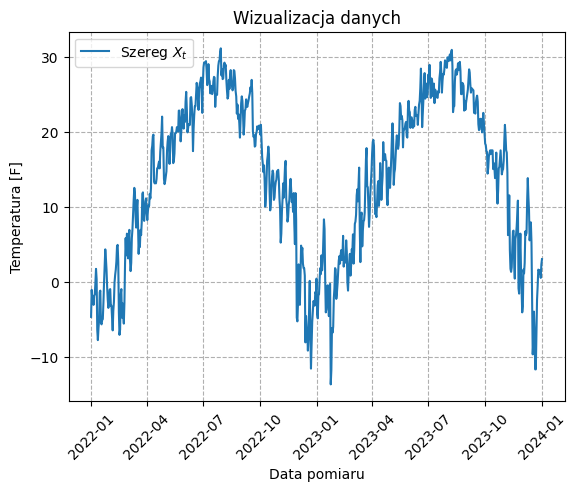

In [46]:
plt.plot(datetime, windspeed, label = 'Szereg $X_t$')
plt.grid(True, linestyle = '--')
plt.ylabel('Temperatura [F]')
plt.xlabel('Data pomiaru')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Wizualizacja danych")
plt.savefig('Temperature_data.png', bbox_inches='tight')
plt.show()

## 2. Przygotowanie danych do analizy

    2.1. Jakość danych

- zakres badanych wartości

In [47]:
# minimalna i maksymalna prędkość wiatru
min_wind = np.min(windspeed)
max_wind = np.max(windspeed)

print('Minimalna prędkość wiatru w danych:', min_wind)
print('Maksymalna prędkość wiatru w danych:', max_wind)

Minimalna prędkość wiatru w danych: -13.7
Maksymalna prędkość wiatru w danych: 31.1


- niekompletne dane: NIE

In [48]:
data_clean.isnull().sum()

datetime    0
temp        0
dtype: int64

    2.2. Dekompozycja szeregu czasowego

-  wykres ACF oraz PACF dla surowych danych - EMPIRYCZNIE

In [49]:
def autokowariancja_emp(x, h):
    n = len(x)
    autocov = np.zeros(len(h))
    for j, hi in enumerate(h):
        if hi < n:
            autocov[j] = (1 / n) * np.sum((x[:n - hi] - np.mean(x)) * (x[hi:] - np.mean(x)))
        else:
            autocov[j] = 0
    return autocov

In [50]:
def autokorelacja_emp(x, h):
    autocov = autokowariancja_emp(x, h)
    autocov_0 = autocov[0] 
    autokor = autocov / autocov_0
    return autokor

In [51]:
def partialautocor(x, h):
    gamma_hat = autokowariancja_emp(x, h)
    pacf = np.zeros(len(h))
    pacf[0] = 1.0 
    for k in range(1, len(h)):
        gamma_matrix = np.array([[gamma_hat[abs(i - j)] for j in range(k)] for i in range(k)])
        gamma_vector = gamma_hat[1 : k + 1]
        phi_k = np.linalg.solve(gamma_matrix, gamma_vector)
        pacf[k] = phi_k[-1]
    return pacf

In [52]:
Xt = windspeed.values
Xt= Xt[Xt <= 40]
h = 40

In [53]:
h_range = np.arange(h+1)
ACF_emp = autokorelacja_emp(x = Xt, h = h_range)
PACF_emp = partialautocor(x = Xt, h = h_range)

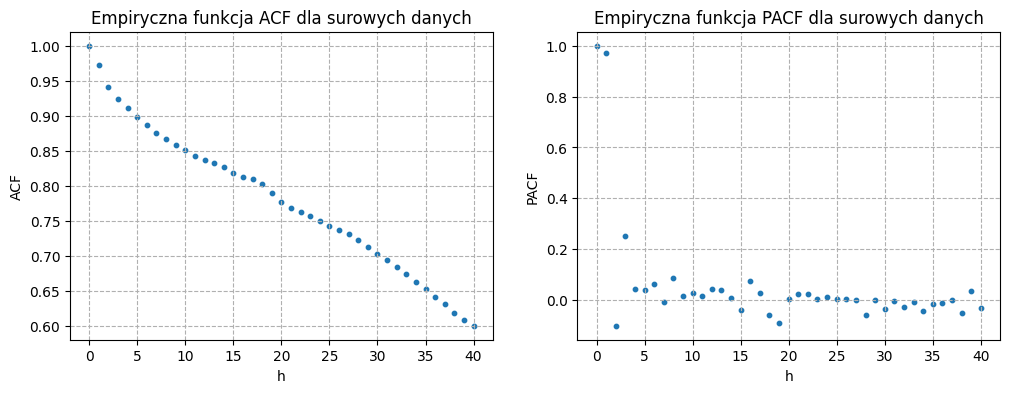

In [54]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(h_range, ACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja ACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('ACF')

plt.subplot(1,2,2)
plt.scatter(h_range, PACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja PACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('PACF')


plt.show()

-  wykres ACF oraz PACF dla surowych danych - WBUDOWANA FUNKCJA (statsmodels)

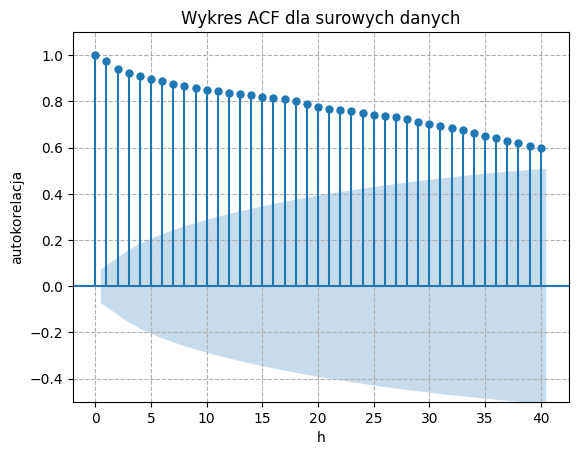

In [55]:
plot_acf(Xt, lags=h)
plt.title("Wykres ACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_raw_data.png', bbox_inches='tight')
plt.show()

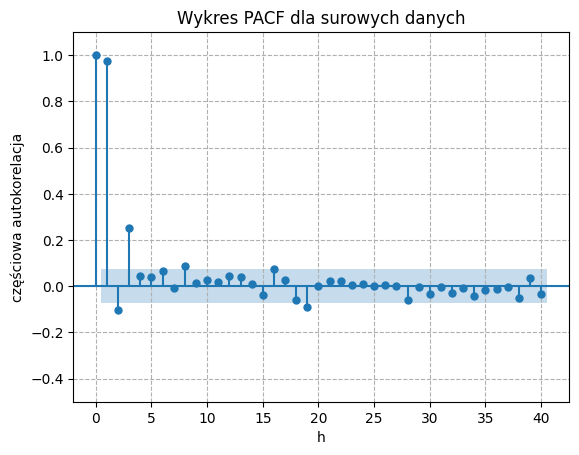

In [56]:
plot_pacf(Xt, lags=h, method='ywm')
plt.title("Wykres PACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_raw_data.png', bbox_inches='tight')
plt.show()


    2.3. Identyfikacja trendów deterministycznych

$$ X_t = m(t) + s(t) + Y(t)  $$

- trend m(t)

In [57]:
n = len(Xt)
t = np.linspace(0, n, n)
m_fit = np.polyfit(t, Xt, 1)
mt = np.polyval(m_fit, t)

In [58]:
delta_Xtm = Xt - mt

- sezonowość s(t)

In [59]:
def s_func_para(t, a, b, c):
    return a*np.sin(b*t + c) 

In [60]:
a_initial = (Xt.max() - Xt.min()) / 2
b_initial = 2 * np.pi / 365
c_initial = 0
d_initial = np.mean(Xt)

params, covariance = curve_fit(s_func_para, t, delta_Xtm, p0=[a_initial, b_initial, c_initial])

a_fit, b_fit, c_fit = params
st = s_func_para(t, a_fit, b_fit, c_fit)

In [61]:
params

array([-14.0836716 ,   0.01709313,   1.36406821])

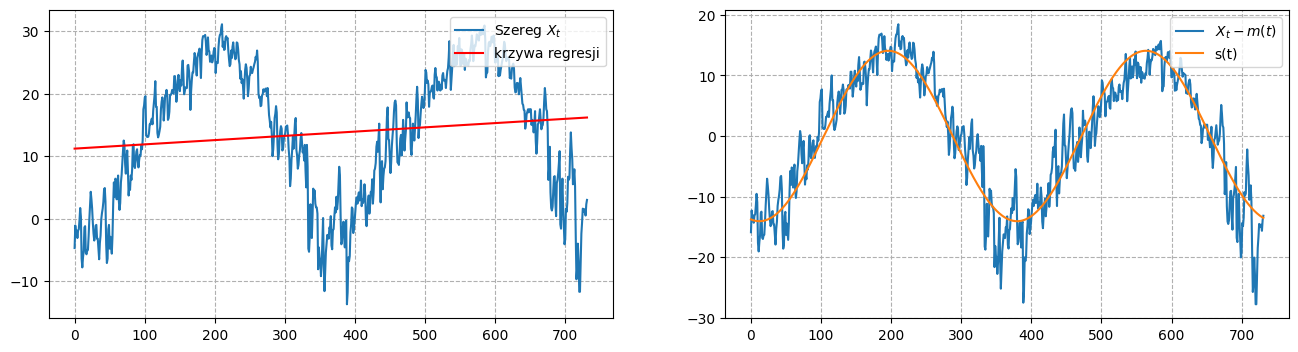

In [62]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(t, Xt, label = 'Szereg $X_t$')
plt.plot(t, mt, color = 'red', label = 'krzywa regresji')
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.subplot(1,2,2)
plt.plot(t, delta_Xtm, label = '$X_t - m(t) $')
plt.plot(t, st, label = 's(t)')
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.show()

- Szereg czasowy liniowy $Y_t$

In [63]:
Yt = Xt - mt - st

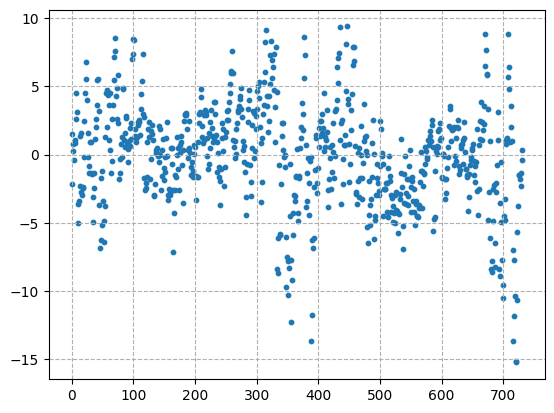

In [64]:
plt.scatter(t, Yt, s=10, label = 'Szereg $Y_t$')
plt.grid(True, linestyle='--')
plt.show()

    2.4. Wykres ACF oraz PACF dla uzyskanego szeregu

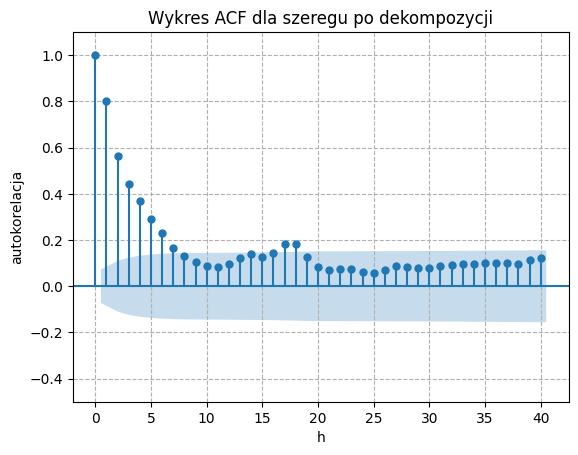

In [65]:
plot_acf(Yt, lags=h)
plt.title("Wykres ACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_data.png', bbox_inches='tight')
plt.show()

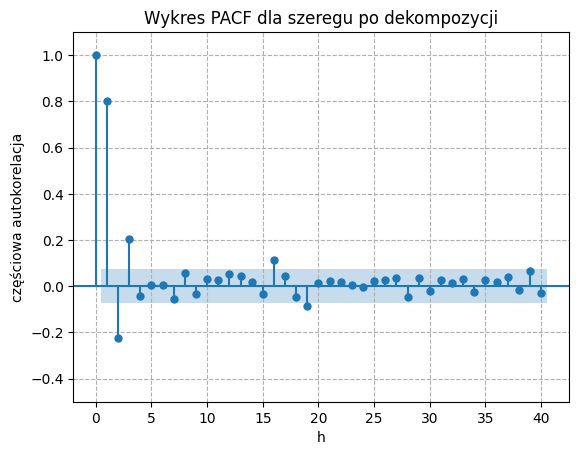

In [66]:
#zmiana: w plot_pacf podany był szereg Xt (sprzed dekompozycji)
plot_pacf(Yt, lags=h, method='ywm')
plt.title("Wykres PACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_data.png', bbox_inches='tight')
plt.show()


## 3. Modelowanie danych przy pomocy ARMA

    3.1. Dobranie rzędu modelu (kryteria informacyjne)

In [79]:
p_values = []
q_values = []
BIC = []
AIC = []
HQIC = []
df = pd.DataFrame()

max_p = 4
max_q = 4

for p in range(0, max_p):
    for q in range(0, max_q):
        
        arima_model = ARIMA(Yt, order=(p, 0, q))
        arima_model_fit = arima_model.fit()
        
        p_values.append(p)
        q_values.append(q)
        AIC.append(arima_model_fit.aic)
        BIC.append(arima_model_fit.bic)
        HQIC.append(arima_model_fit.hqic)

df['p'] = p_values
df['q'] = q_values
df['AIC'] = AIC
df['BIC'] = BIC
df['HQIC'] = HQIC


c:\Users\Magdalena\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [80]:
#posortowanie wartości wg wartości AIC (od najmniejszej)
print(df.sort_values(by='AIC').head())

    p  q          AIC          BIC         HQIC
11  2  3  3190.864229  3223.025124  3203.271349
15  3  3  3192.456612  3229.211919  3206.636177
12  3  0  3192.662536  3215.634603  3201.524765
13  3  1  3193.232215  3220.798696  3203.866889
7   1  3  3193.724870  3221.291351  3204.359544


In [81]:
#posortowanie wartości wg wartości BIC (od najmniejszej)
print(df.sort_values(by='BIC').head())

    p  q          AIC          BIC         HQIC
12  3  0  3192.662536  3215.634603  3201.524765
5   1  1  3199.642787  3218.020441  3206.732570
6   1  2  3196.572149  3219.544216  3205.434377
13  3  1  3193.232215  3220.798696  3203.866889
7   1  3  3193.724870  3221.291351  3204.359544


In [82]:
#posortowanie wartości wg wartości HQIC (od najmniejszej)
print(df.sort_values(by='HQIC').head())

    p  q          AIC          BIC         HQIC
12  3  0  3192.662536  3215.634603  3201.524765
11  2  3  3190.864229  3223.025124  3203.271349
13  3  1  3193.232215  3220.798696  3203.866889
7   1  3  3193.724870  3221.291351  3204.359544
6   1  2  3196.572149  3219.544216  3205.434377


    3.2. Estymacja parametrów modelu wybraną metodą.

##  4. Ocena dopasowania modelu

    4.1. Przedziały ufności dla PACF/ACF

    4.2. Porównanie linii kwantylowych z trajektorią

## 5. Weryfikacja założeń dotyczących szumu

    5.1. Założenie dot. średniej (wykres wartości resztowych / t test)

    5.2. Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

    5.3. Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

    5.4. Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

## 6. Podsumowanie